In [31]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve
)
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


In [32]:
# Load dataset
df = pd.read_csv('../data/ai4i2020.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n" + "=" * 80)
print("FIRST 5 ROWS")
print("=" * 80)
print(df.head())

print("\n" + "=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
print(df.info())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
print(df.isnull().sum())

print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
print(df.describe())


DATASET OVERVIEW

Dataset Shape: 10000 rows × 14 columns

FIRST 5 ROWS
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.

TARGET VARIABLE ANALYSIS

Machine Failure Distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64

Failure Rate: 3.39%


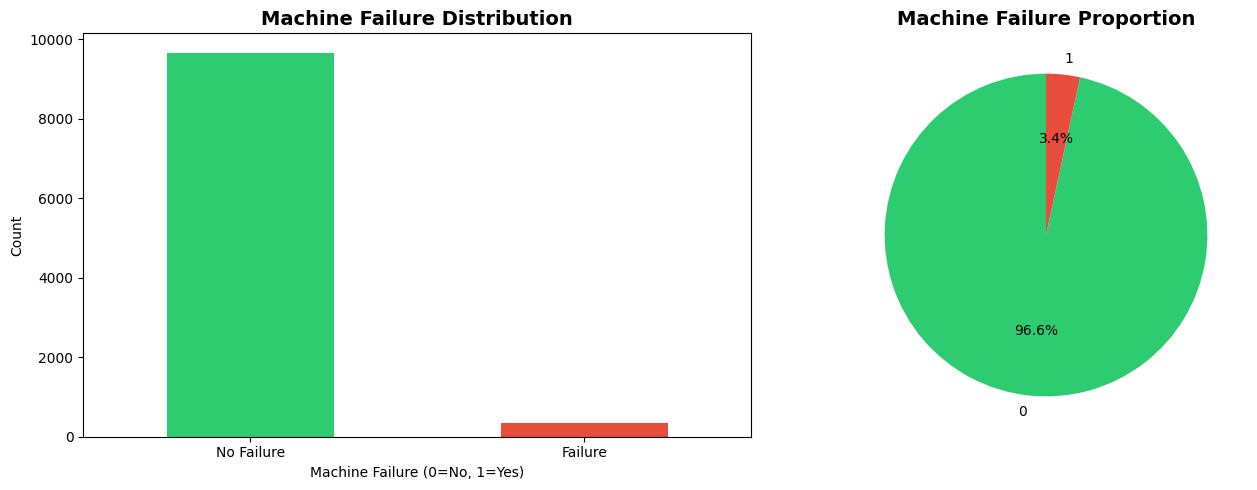


FAILURE TYPE BREAKDOWN
TWF: 46 failures (0.46%)
HDF: 115 failures (1.15%)
PWF: 95 failures (0.95%)
OSF: 98 failures (0.98%)
RNF: 19 failures (0.19%)


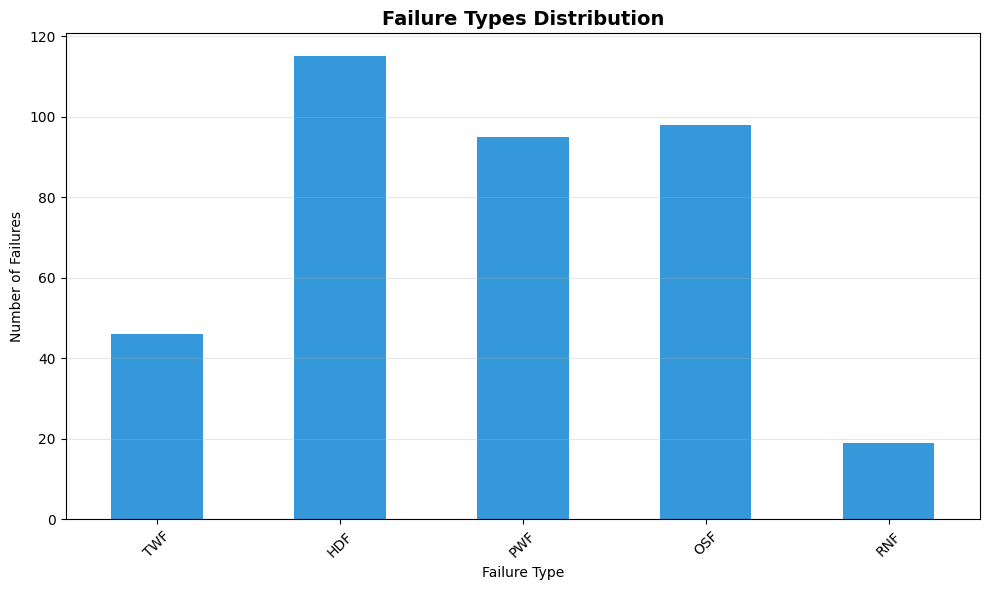

In [33]:
# Target variable distribution
print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

print("\nMachine Failure Distribution:")
print(df['Machine failure'].value_counts())
print(f"\nFailure Rate: {df['Machine failure'].mean() * 100:.2f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['Machine failure'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Machine Failure Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Machine Failure (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Failure', 'Failure'], rotation=0)

# Pie chart
df['Machine failure'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                          colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Machine Failure Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Failure type analysis
print("\n" + "=" * 80)
print("FAILURE TYPE BREAKDOWN")
print("=" * 80)
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for failure in failure_types:
    count = df[failure].sum()
    percentage = (count / len(df)) * 100
    print(f"{failure}: {count} failures ({percentage:.2f}%)")

# Visualize failure types
failure_counts = df[failure_types].sum()
plt.figure(figsize=(10, 6))
failure_counts.plot(kind='bar', color='#3498db')
plt.title('Failure Types Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Failure Type')
plt.ylabel('Number of Failures')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


PRODUCT TYPE ANALYSIS

Product Type Distribution:
Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

Failure Rate by Product Type:
      Total Failures  Total Products  Failure Rate
Type                                              
H                 21            1003      2.093719
L                235            6000      3.916667
M                 83            2997      2.769436


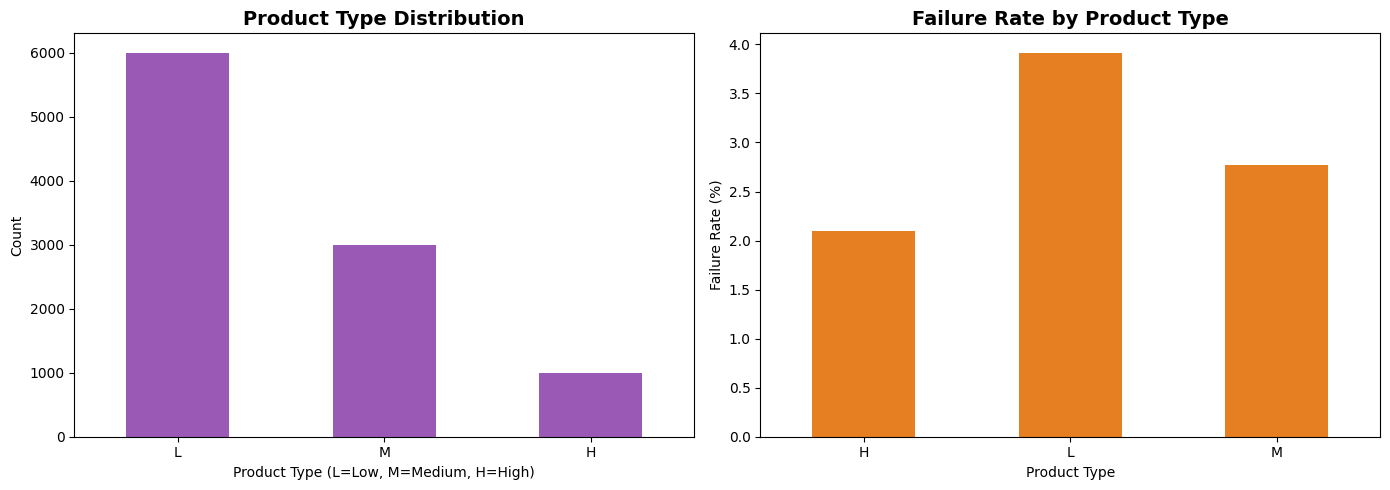

In [34]:
# Product Type Analysis
print("=" * 80)
print("PRODUCT TYPE ANALYSIS")
print("=" * 80)

print("\nProduct Type Distribution:")
print(df['Type'].value_counts())

# Failure rate by product type
failure_by_type = df.groupby('Type')['Machine failure'].agg(['sum', 'count', 'mean'])
failure_by_type.columns = ['Total Failures', 'Total Products', 'Failure Rate']
failure_by_type['Failure Rate'] = failure_by_type['Failure Rate'] * 100
print("\nFailure Rate by Product Type:")
print(failure_by_type)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Product type distribution
df['Type'].value_counts().plot(kind='bar', ax=axes[0], color='#9b59b6')
axes[0].set_title('Product Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Product Type (L=Low, M=Medium, H=High)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Failure rate by product type
failure_by_type['Failure Rate'].plot(kind='bar', ax=axes[1], color='#e67e22')
axes[1].set_title('Failure Rate by Product Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Product Type')
axes[1].set_ylabel('Failure Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


NUMERICAL FEATURES DISTRIBUTION


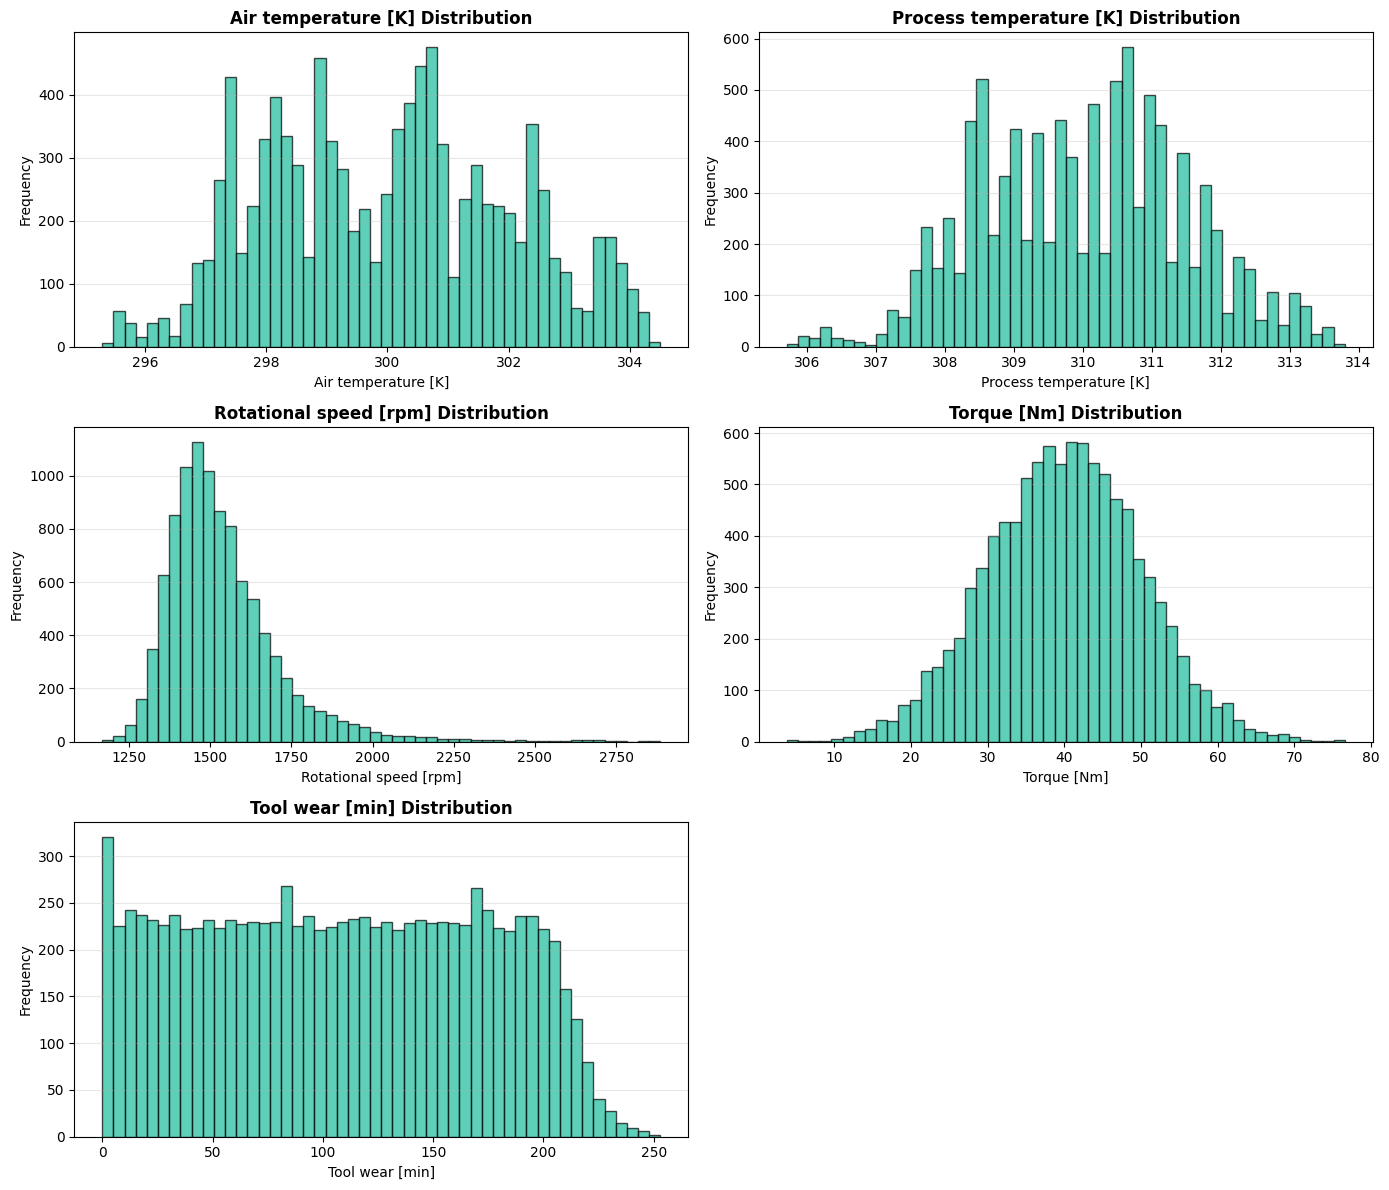

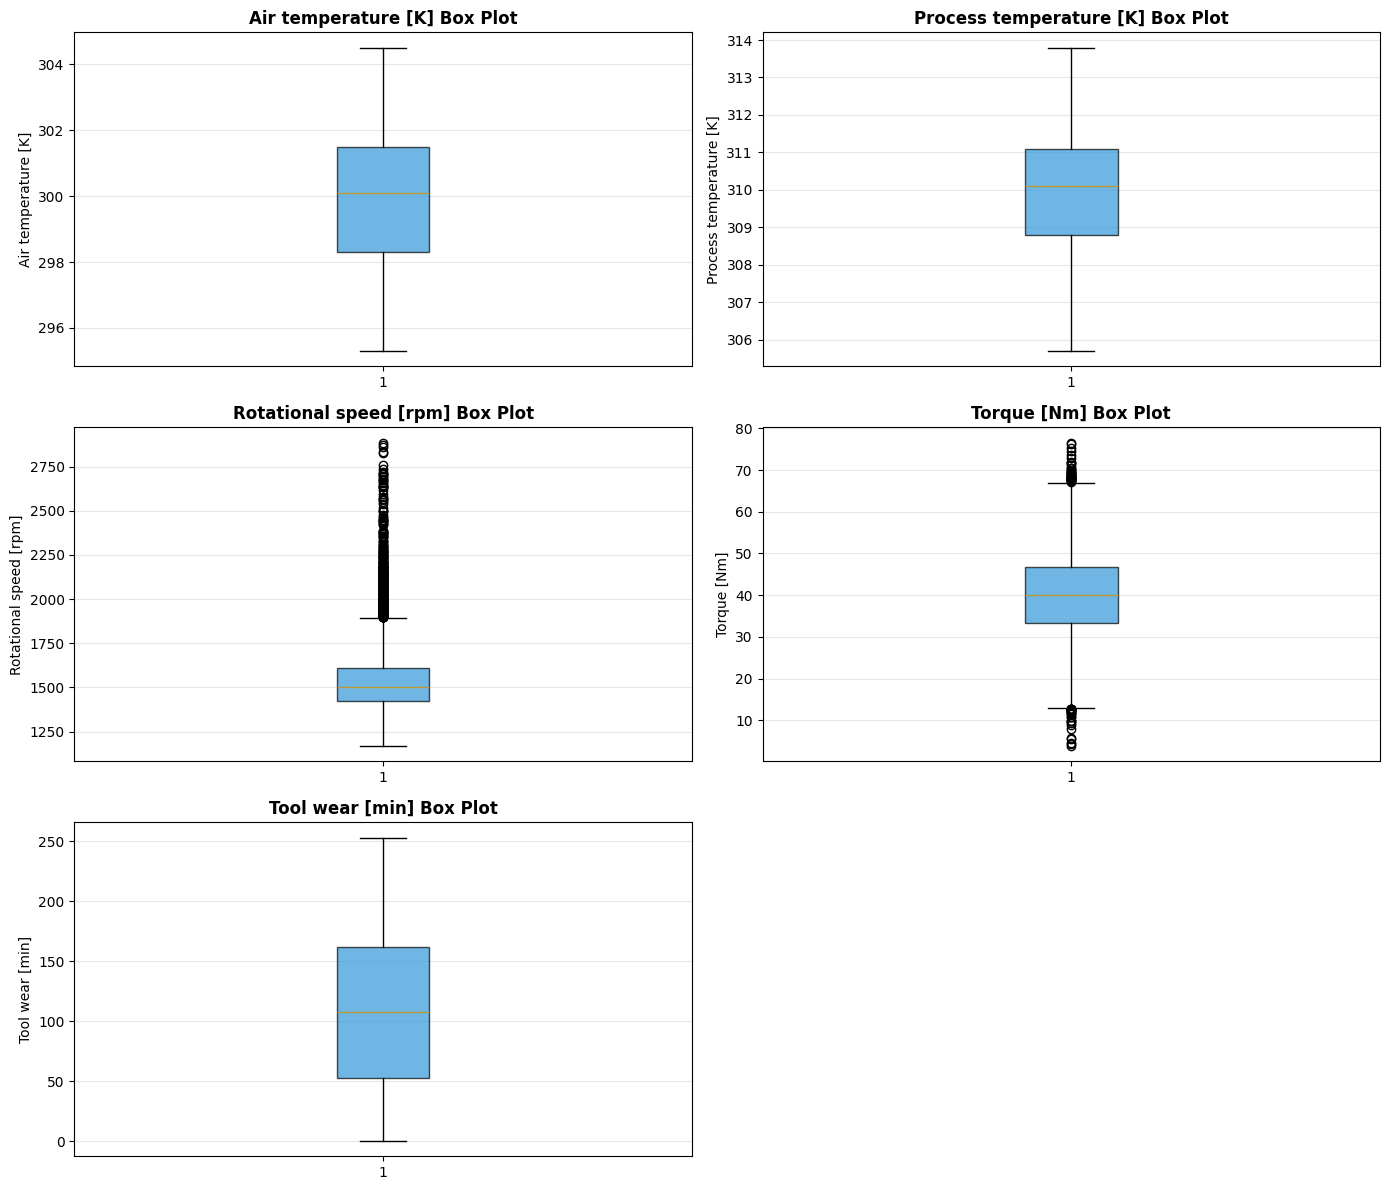

In [35]:
# Numerical features distribution
print("=" * 80)
print("NUMERICAL FEATURES DISTRIBUTION")
print("=" * 80)

numerical_features = ['Air temperature [K]', 'Process temperature [K]', 
                     'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df[feature], bins=50, color='#1abc9c', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

axes[5].axis('off')  # Hide the 6th subplot
plt.tight_layout()
plt.show()

# Box plots to detect outliers
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    axes[idx].boxplot(df[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='#3498db', alpha=0.7))
    axes[idx].set_title(f'{feature} Box Plot', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(axis='y', alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

Correlation with Machine Failure:
Machine failure            1.000000
HDF                        0.575800
OSF                        0.531083
PWF                        0.522812
TWF                        0.362904
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
RNF                        0.004516
Rotational speed [rpm]    -0.044188
Name: Machine failure, dtype: float64


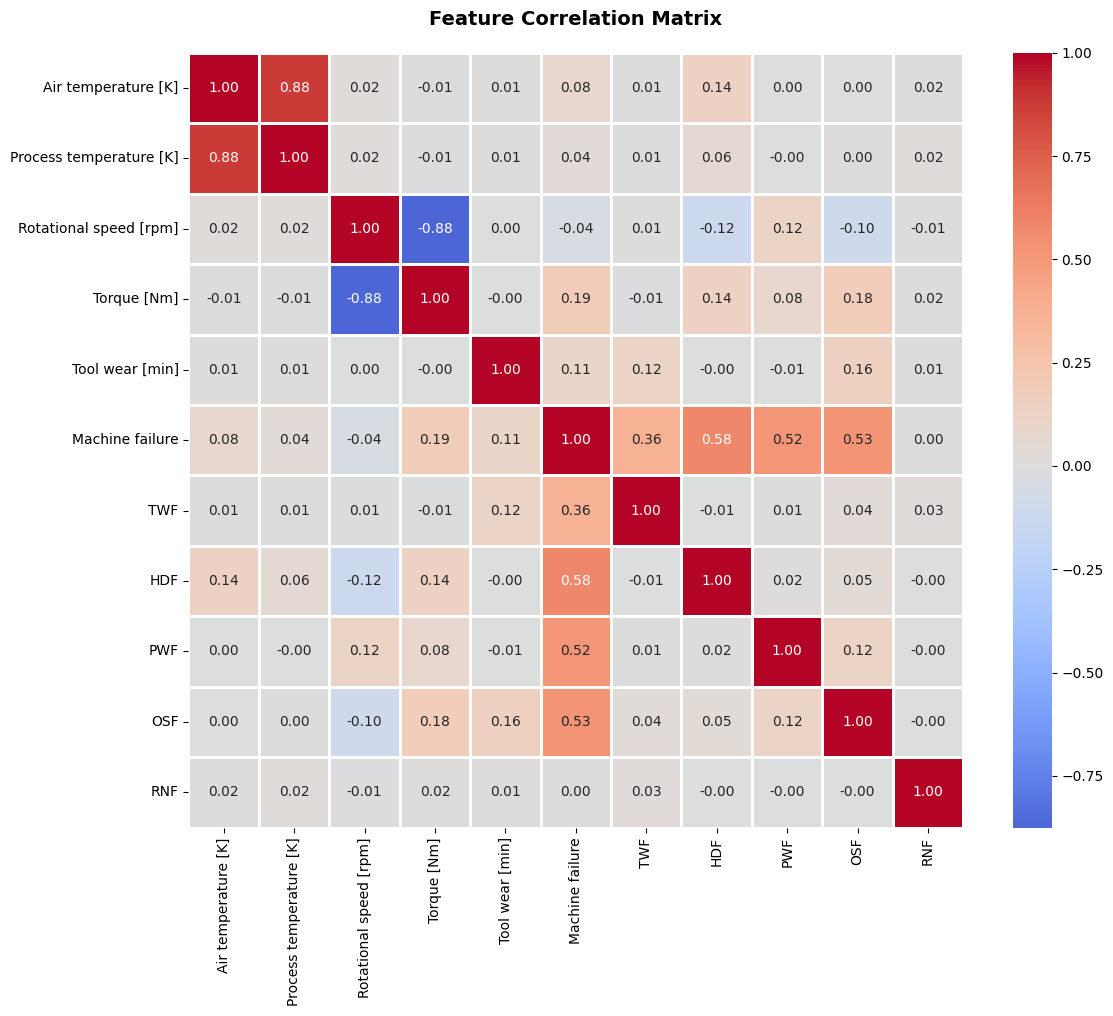

In [36]:
# Correlation analysis
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove identifiers
numerical_cols = [col for col in numerical_cols if col not in ['UDI']]

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Display correlation with target variable
print("\nCorrelation with Machine Failure:")
target_corr = correlation_matrix['Machine failure'].sort_values(ascending=False)
print(target_corr)

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


FEATURE COMPARISON: FAILURE VS NO FAILURE


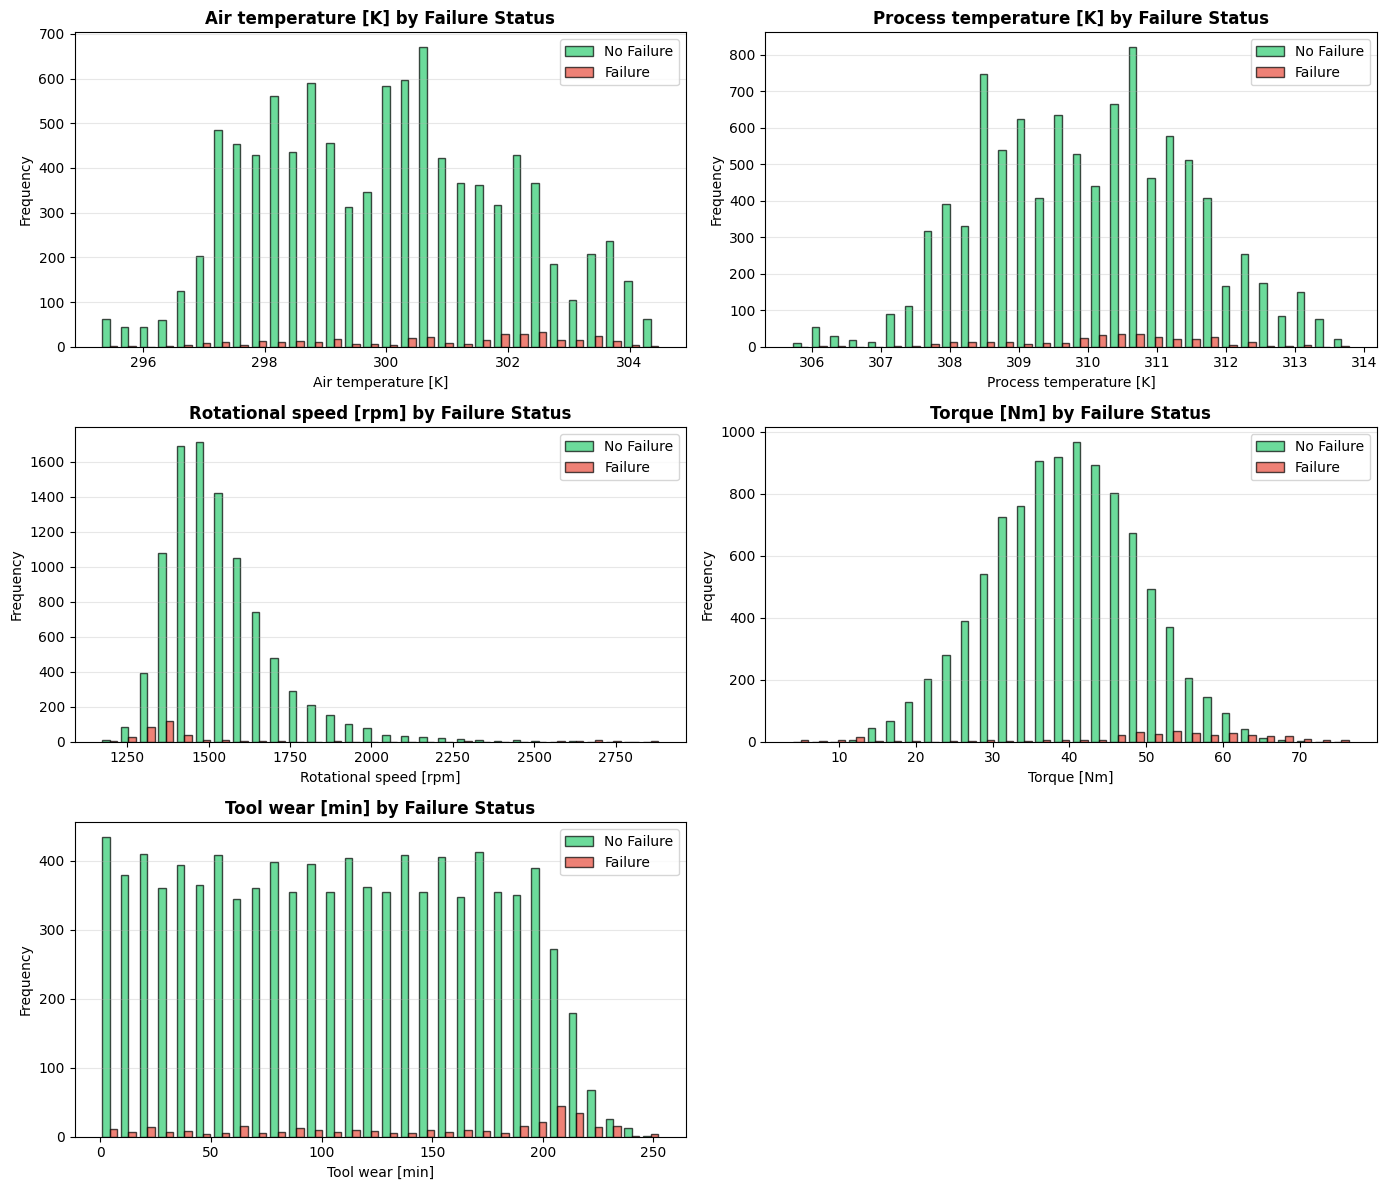


Feature Statistics by Failure Status:

Air temperature [K]:
                       mean       std    min    max
Machine failure                                    
0                299.973999  1.990748  295.3  304.5
1                300.886431  2.071473  295.6  304.4

Process temperature [K]:
                       mean       std    min    max
Machine failure                                    
0                309.995570  1.486846  305.7  313.8
1                310.290265  1.363686  306.1  313.7

Rotational speed [rpm]:
                        mean         std     min     max
Machine failure                                         
0                1540.260014  167.394734  1168.0  2695.0
1                1496.486726  384.943547  1181.0  2886.0

Torque [Nm]:
                      mean        std   min   max
Machine failure                                  
0                39.629655   9.472080  12.6  70.0
1                50.168142  16.374498   3.8  76.6

Tool wear [min]:
            

In [37]:
# Compare features for failed vs non-failed machines
print("=" * 80)
print("FEATURE COMPARISON: FAILURE VS NO FAILURE")
print("=" * 80)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    # Separate data by failure status
    no_failure = df[df['Machine failure'] == 0][feature]
    failure = df[df['Machine failure'] == 1][feature]
    
    axes[idx].hist([no_failure, failure], bins=30, label=['No Failure', 'Failure'],
                   color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{feature} by Failure Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.show()

# Statistical comparison
print("\nFeature Statistics by Failure Status:")
print("=" * 80)
for feature in numerical_features:
    print(f"\n{feature}:")
    print(df.groupby('Machine failure')[feature].describe()[['mean', 'std', 'min', 'max']])


In [38]:
# Data Preparation
print("=" * 80)
print("DATA PREPARATION & FEATURE ENGINEERING")
print("=" * 80)

# Create a copy
df_model = df.copy()

# Drop unnecessary columns
columns_to_drop = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df_model = df_model.drop(columns=columns_to_drop)

# Rename columns to remove special characters (brackets) for XGBoost compatibility
df_model = df_model.rename(columns={
    'Air temperature [K]': 'Air_temperature_K',
    'Process temperature [K]': 'Process_temperature_K',
    'Rotational speed [rpm]': 'Rotational_speed_rpm',
    'Torque [Nm]': 'Torque_Nm',
    'Tool wear [min]': 'Tool_wear_min'
})

print(f"\nColumns renamed (removed brackets for XGBoost compatibility)")
print(f"Remaining columns: {df_model.columns.tolist()}")
print(f"Dataset shape: {df_model.shape}")

# Encode categorical variable (Type)
le = LabelEncoder()
df_model['Type_encoded'] = le.fit_transform(df_model['Type'])
print(f"\nType encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Drop original Type column
df_model = df_model.drop('Type', axis=1)

# Feature engineering - create interaction features
df_model['Temp_diff'] = df_model['Process_temperature_K'] - df_model['Air_temperature_K']
df_model['Power_factor'] = df_model['Torque_Nm'] * df_model['Rotational_speed_rpm']

print(f"\nNew engineered features:")
print("- Temp_diff: Temperature difference (Process - Air)")
print("- Power_factor: Torque × Rotational speed")

print(f"\nFinal dataset shape: {df_model.shape}")
print(f"Features: {[col for col in df_model.columns if col != 'Machine failure']}")

# Split features and target
X = df_model.drop('Machine failure', axis=1)
y = df_model['Machine failure']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training failure rate: {y_train.mean() * 100:.2f}%")
print(f"Test failure rate: {y_test.mean() * 100:.2f}%")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")
print(f"✓ Feature names cleaned for XGBoost compatibility")



DATA PREPARATION & FEATURE ENGINEERING

Columns renamed (removed brackets for XGBoost compatibility)
Remaining columns: ['Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Machine failure']
Dataset shape: (10000, 7)

Type encoding: {'H': np.int64(0), 'L': np.int64(1), 'M': np.int64(2)}

New engineered features:
- Temp_diff: Temperature difference (Process - Air)
- Power_factor: Torque × Rotational speed

Final dataset shape: (10000, 9)
Features: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Type_encoded', 'Temp_diff', 'Power_factor']

TRAIN-TEST SPLIT
Training set: 8000 samples
Test set: 2000 samples
Training failure rate: 3.39%
Test failure rate: 3.40%

✓ Features scaled using StandardScaler
✓ Feature names cleaned for XGBoost compatibility


In [39]:
# Split features and target
X = df_model.drop('Machine failure', axis=1)
y = df_model['Machine failure']

print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set failure rate: {y_train.mean() * 100:.2f}%")
print(f"Test set failure rate: {y_test.mean() * 100:.2f}%")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")
print("Mean ~ 0, Standard Deviation ~ 1")


TRAIN-TEST SPLIT

Training set size: 8000 samples
Test set size: 2000 samples

Training set failure rate: 3.39%
Test set failure rate: 3.40%

Features scaled using StandardScaler
Mean ~ 0, Standard Deviation ~ 1


In [40]:
# Train Logistic Regression
print("=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nLogistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Failure', 'Failure']))


MODEL 1: LOGISTIC REGRESSION

Logistic Regression Performance:
Accuracy:  0.8600
Precision: 0.1807
Recall:    0.8824
F1-Score:  0.3000
ROC-AUC:   0.9330

Confusion Matrix:
[[1660  272]
 [   8   60]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.86      0.92      1932
     Failure       0.18      0.88      0.30        68

    accuracy                           0.86      2000
   macro avg       0.59      0.87      0.61      2000
weighted avg       0.97      0.86      0.90      2000



In [41]:
# Train Decision Tree
print("=" * 80)
print("MODEL 2: DECISION TREE")
print("=" * 80)

dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20, 
                            min_samples_leaf=10, class_weight='balanced')
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluation
print("\nDecision Tree Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_dt):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance_dt.head())


MODEL 2: DECISION TREE

Decision Tree Performance:
Accuracy:  0.9570
Precision: 0.4338
Recall:    0.8676
F1-Score:  0.5784
ROC-AUC:   0.9291

Confusion Matrix:
[[1855   77]
 [   9   59]]

Top 5 Important Features:
                Feature  Importance
2  Rotational_speed_rpm    0.332443
4         Tool_wear_min    0.276950
7          Power_factor    0.231424
3             Torque_Nm    0.103146
6             Temp_diff    0.036787


MODEL 3: RANDOM FOREST

Random Forest Performance:
Accuracy:  0.9900
Precision: 0.8636
Recall:    0.8382
F1-Score:  0.8507
ROC-AUC:   0.9741

Confusion Matrix:
[[1923    9]
 [  11   57]]

Top 5 Important Features:
                Feature  Importance
2  Rotational_speed_rpm    0.226002
3             Torque_Nm    0.200920
4         Tool_wear_min    0.198742
7          Power_factor    0.189004
6             Temp_diff    0.085787


<Figure size 1000x600 with 0 Axes>

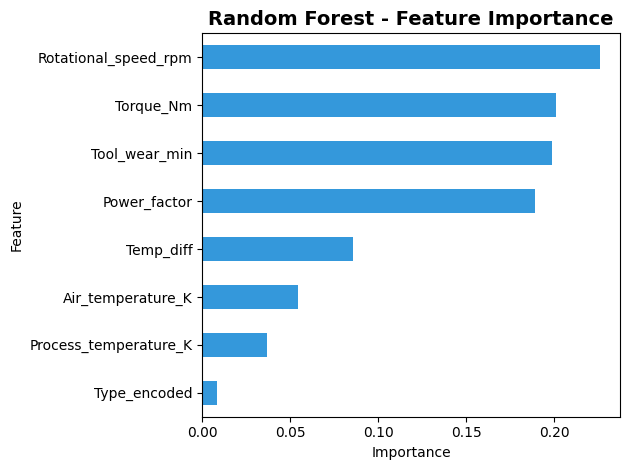

In [42]:
# Train Random Forest
print("=" * 80)
print("MODEL 3: RANDOM FOREST")
print("=" * 80)

rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15,
                           min_samples_split=10, min_samples_leaf=5, 
                           class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nRandom Forest Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance_rf.head())

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance_rf.plot(x='Feature', y='Importance', kind='barh', 
                           color='#3498db', legend=False)
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [43]:
# Train XGBoost
print("=" * 80)
print("MODEL 4: XGBOOST")
print("=" * 80)

# Calculate scale_pos_weight for imbalanced dataset
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nXGBoost Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance_xgb.head())



MODEL 4: XGBOOST

Scale pos weight: 28.52

XGBoost Performance:
Accuracy:  0.9815
Precision: 0.6962
Recall:    0.8088
F1-Score:  0.7483
ROC-AUC:   0.9774

Confusion Matrix:
[[1908   24]
 [  13   55]]

Top 5 Important Features:
                Feature  Importance
2  Rotational_speed_rpm    0.336102
7          Power_factor    0.193379
4         Tool_wear_min    0.189070
3             Torque_Nm    0.139010
6             Temp_diff    0.056746


MODEL COMPARISON




,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.8600,0.180723,0.882353,0.300000,0.932986
1,Decision Tree,0.9570,0.433824,0.867647,0.578431,0.929078
2,Random Forest,0.9900,0.863636,0.838235,0.850746,0.974082
3,XGBoost,0.9815,0.696203,0.808824,0.748299,0.977370


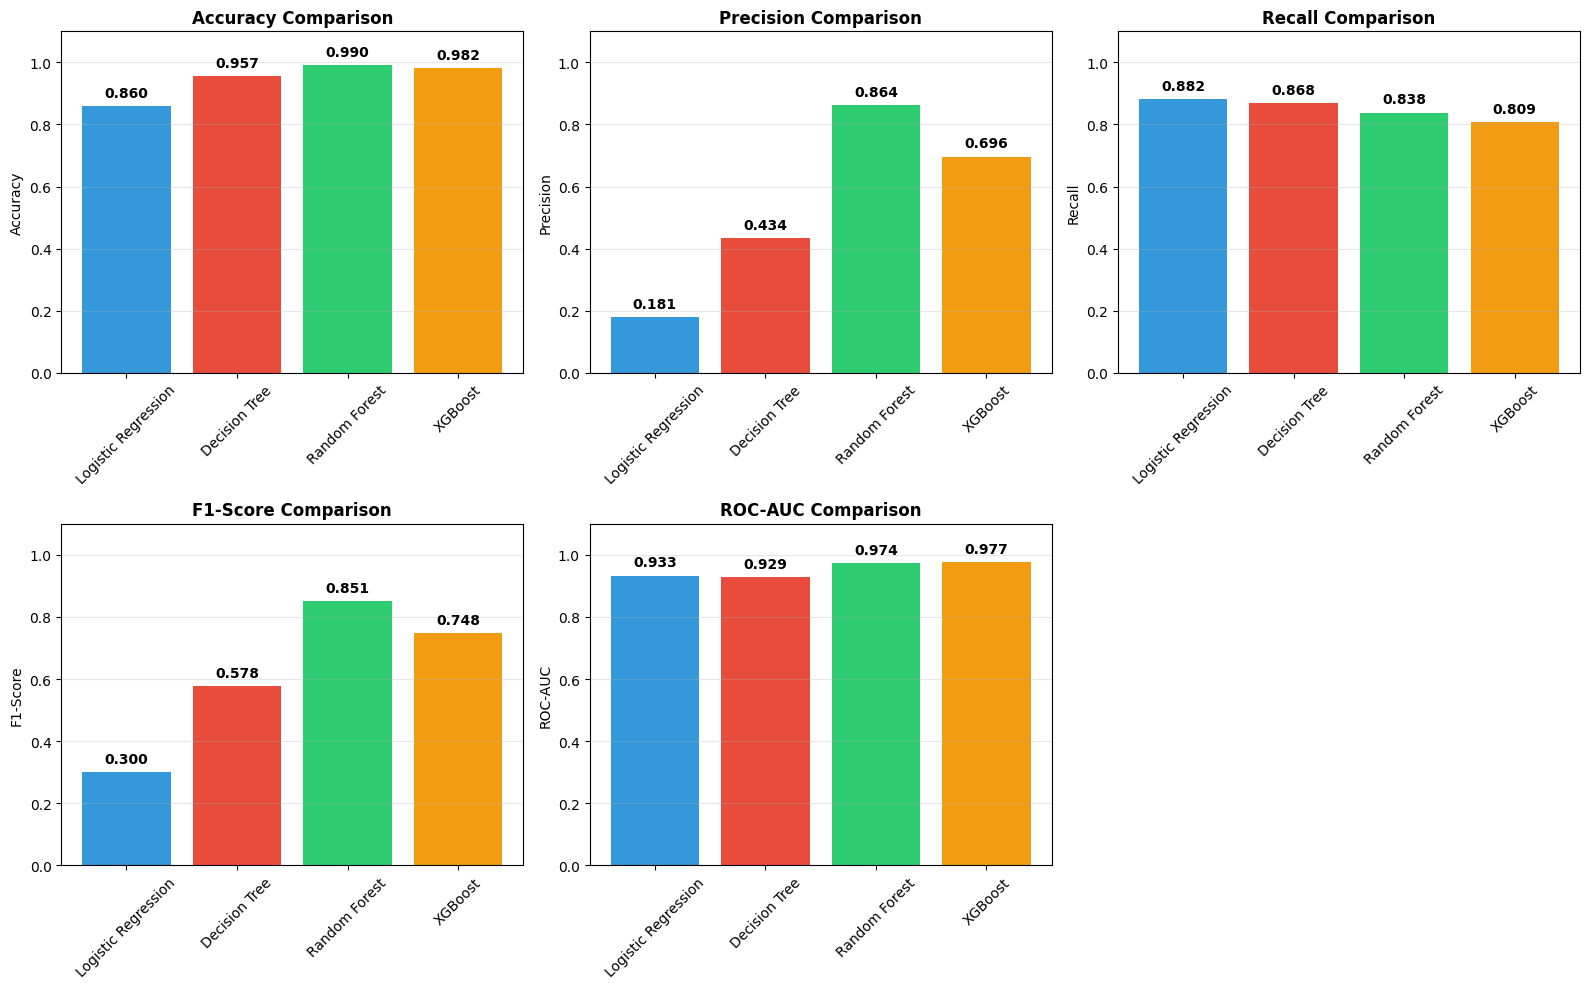


🏆 BEST MODEL: Random Forest
F1-Score: 0.8507


In [44]:
# Compare all models
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_dt),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
})

print("\n")
display(models_comparison)

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    axes[idx].bar(models_comparison['Model'], models_comparison[metric], color=colors)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(models_comparison[metric]):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

axes[5].axis('off')
plt.tight_layout()
plt.show()

# Best model
best_model_idx = models_comparison['F1-Score'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"F1-Score: {models_comparison.loc[best_model_idx, 'F1-Score']:.4f}")


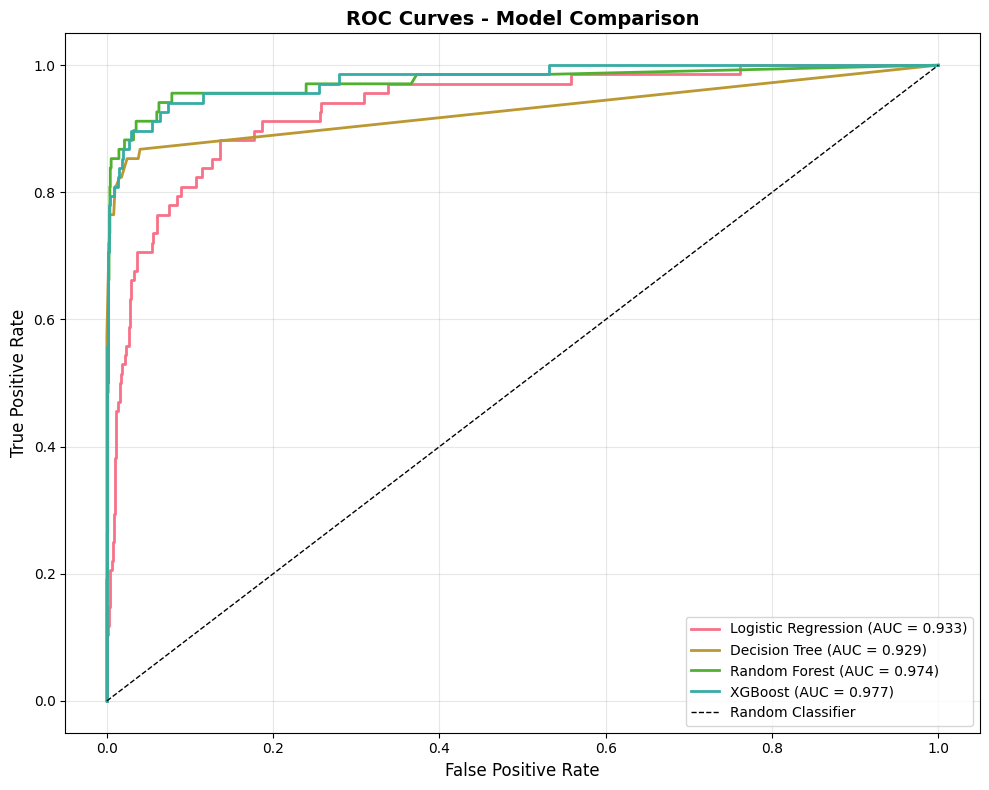

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_pred_proba_dt):.3f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [46]:
# Cell 16: Save Models
import pickle

# Save the best model and preprocessing objects
print("=" * 80)
print("SAVING MODELS AND PREPROCESSING OBJECTS")
print("=" * 80)

# Determine best model based on F1-score
best_model = xgb_model  # Change if another model performed better

# Save model
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\n✓ Best model saved to: models/model.pkl")

# Save scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved to: models/scaler.pkl")

# Save label encoder
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("✓ Label Encoder saved to: models/label_encoder.pkl")

print("\n" + "=" * 80)
print("✅ NOTEBOOK COMPLETE!")
print("=" * 80)
print("\nNext steps:")
print("1. Create train.py script")
print("2. Create predict.py script")
print("3. Create Dockerfile")
print("4. Deploy the model")


SAVING MODELS AND PREPROCESSING OBJECTS

✓ Best model saved to: models/model.pkl
✓ Scaler saved to: models/scaler.pkl
✓ Label Encoder saved to: models/label_encoder.pkl

✅ NOTEBOOK COMPLETE!

Next steps:
1. Create train.py script
2. Create predict.py script
3. Create Dockerfile
4. Deploy the model
